In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from scipy.stats import skew, kurtosis

torch.cuda.empty_cache()
# imports of custom blocks for model, data generation
from Ferret.ImplicitAm import ImplicitAmBre, ImplicitAmBer
from create_plots import *
from models import *
from utils import AmericanCallData, get_prices_call
from utils import S, T, K, RISK_FREE, SIGMA, S_MAX

## Call Option

### Content: 
1. **Generating Data**
2. **Training on Generated Data, Testing Both on Generated and Real Data**
3. **Training on Real Data, Testing on Real Data**
4. **Mixture of Data (70/30, 50/50), Testing on Real Data**


In [ ]:
call_data = AmericanCallData(t_range=T, S_range=S, K=K, r=RISK_FREE, sigma=SIGMA)
# N_ivp - IVP points
# N_bvp - both BVP1 and BVP2 points
# N_col - colocation points
X = call_data.initialize_data(N_ivp=1000, N_bvp=3000, N_col=6000, is_call=True)
option = ImplicitAmBer(
    S[0],
    K,
    RISK_FREE,
    T[1],
    SIGMA,
    S_MAX,
    M=400,  # S
    N=365 * 3,  # t
    is_call=False,
)
option.price()
option_fde_prices = option.grid
data = get_prices_call(X, option_fde_prices, generated=True)
df = pd.DataFrame(
    data=data,
    columns=[
        "TimeToExp",
        "UnderlyingPrice",
        "TargetPrice",
        "OpenInterest",
        "Delta",
        "Gamma",
        "Theta",
        "Vega",
        "BSAprox",
    ],
)
df[["TimeToExp", "UnderlyingPrice", "TargetPrice", "BSAprox"]] = df[
    ["TimeToExp", "UnderlyingPrice", "TargetPrice", "BSAprox"]
].round(2)
df["OpenInterest"] = df["OpenInterest"].round(0)
df.to_csv("../train_data/generated_call.csv")

In [2]:
df = pd.read_csv("../train_data/generated_call.csv",index_col=0)
print(df.shape)
df.head()

(10000, 9)


,TimeToExp,UnderlyingPrice,TargetPrice,OpenInterest,Delta,Gamma,Theta,Vega,BSAprox
0,850.0,122.12,43.00,364.0,0.345992,0.144298,-3.575622,2.522842,31.500
1,311.0,186.19,29.31,514.0,0.167115,0.056784,-2.531811,6.822075,24.655
2,629.0,52.52,69.69,65.0,0.376269,0.272558,-7.814967,5.852912,0.000
3,469.0,144.80,37.75,58.0,0.009575,0.017516,-1.451383,1.604901,0.000
4,0.0,187.07,29.12,91.0,0.441506,0.138325,-8.777276,5.934998,118.970


In [3]:
# Check for ITM and OTM
print(f"ITM count:{np.sum(df.UnderlyingPrice > K)}")
print(f"OTM count:{np.sum(df.UnderlyingPrice <= K)}")

ITM count:4201
OTM count:5799


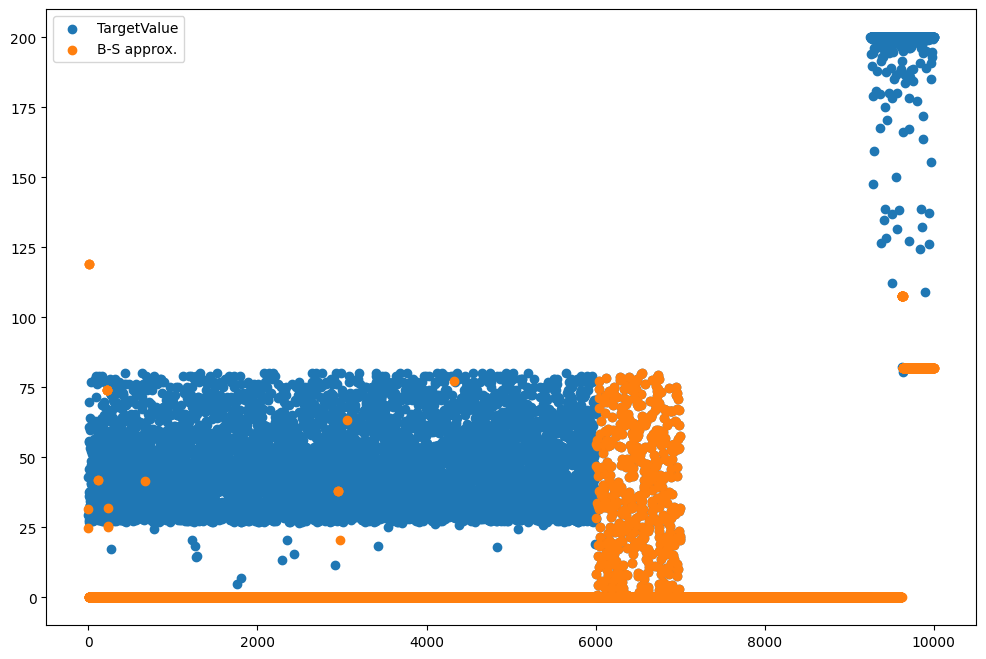

In [30]:
plt.figure(figsize=(12, 8))
plt.scatter(
    x=np.arange(1, len(df.TargetPrice) + 1, 1), y=df.TargetPrice, label="TargetValue"
)
plt.scatter(x=np.arange(1, len(df.BSAprox) + 1, 1), y=df.BSAprox, label="B-S approx.")
plt.legend()
plt.show()

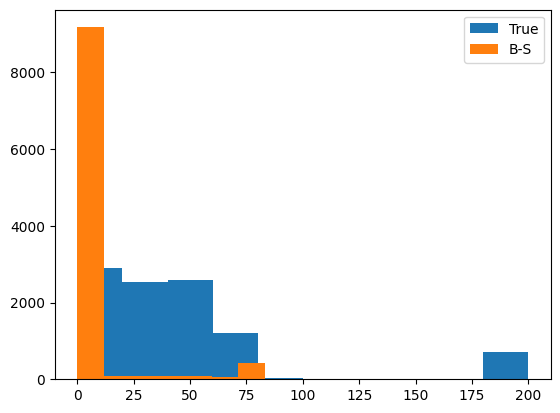

In [5]:
plt.hist(df.TargetPrice, label="Target value")
plt.hist(df.BSAprox, label="B-S")
plt.legend()
plt.show()

In [ ]:
# adding BSAprox column to real data
# Run it once, only if u dont have saved df
df_real = get_prices_call(df_real.to_numpy(), generated=False)
df_real = pd.DataFrame(
    data=df_real,
    columns=[
        [
            "UnderlyingPrice",
            "Type",
            "Strike",
            "OpenInterest",
            "IV",
            "Delta",
            "Gamma",
            "Theta",
            "Vega",
            "Time",
            "TargetPrice",
            "BSAprox",
        ]
    ],
)

df_real["BSAprox"] = df_real["BSAprox"].round(2)
df_real.to_csv("../train_data/call_df_with_approx.csv")

In [2]:
# df_real["BSAprox"] = df_real["BSAprox"].round(2)
# df_real.to_csv("../train_data/call_df_with_approx.csv")
df_real = pd.read_csv("../train_data/call_df_with_approx.csv", index_col=0)
df_real.head()

,UnderlyingPrice,Type,Strike,OpenInterest,IV,Delta,Gamma,Theta,Vega,Time,TargetPrice,BSAprox
0,71.11,call,55.0,0,0.2693,1.0000,0.0000,-1.2654,0.0015,21,16.08,16.11
1,71.11,call,60.0,3,0.2693,0.9968,0.0022,-1.7664,0.1636,21,11.38,11.11
2,71.11,call,62.5,9,0.2693,0.9813,0.0101,-3.2537,0.7659,21,8.50,8.61
3,71.11,call,65.0,16,0.2693,0.9286,0.0302,-6.9022,2.2884,21,6.98,6.11
4,71.11,call,67.5,44,0.2430,0.8313,0.0617,-10.4813,4.2260,21,4.10,3.61


In [3]:
# hyperparams for training
N_EPOCH = 50
RISK_FREE = 0.03
SIGMA = 0.4
LEARNING_RATE = 0.00075178
HIDDEN_LAYER = 24
HIDDEN_WIDTH = 64
EXPERIMENT_NAME = "exp_call_12_gen"
MODEL_TYPE = AmericanPut_gated3
experiment_dir = f"../experiments_dir/{EXPERIMENT_NAME}"
os.makedirs(experiment_dir, exist_ok=True)

In [4]:
import logging
from datetime import datetime

logger = logging.getLogger()
current_date = datetime.now().strftime("%Y-%m-%d")
log_file_name = f"{experiment_dir}/{EXPERIMENT_NAME}_log_{current_date}.log"
fhandler = logging.FileHandler(filename=log_file_name, mode="w")
formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.INFO)

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
# torch.set_default_device(DEVICE)
logging.info(f"Running on device={DEVICE}")

cuda


In [6]:
logging.info(f"N_EPOCH: {N_EPOCH}")
logging.info(f"LEARNING_RATE: {LEARNING_RATE}")
logging.info(f"HIDDEN_LAYER: {HIDDEN_LAYER}")
logging.info(f"HIDDEN_WIDTH: {HIDDEN_WIDTH}")
# logging.info(f"N_sample: {N_sample}")
logging.info(f"EXPERIMENT_NAME: {EXPERIMENT_NAME}")
logging.info(f"Model type: {MODEL_TYPE.__name__}")

In [7]:
# df = df_real.sample(n=20000, random_state=42)
df_train, df_val = train_test_split(df, test_size=0.2)
print(df_train.shape)
print(df_val.shape)

(8000, 9)
(2000, 9)


In [8]:
df_train

,TimeToExp,UnderlyingPrice,TargetPrice,OpenInterest,Delta,Gamma,Theta,Vega,BSAprox
6251,0.00,91.32,0.00,512.0,0.262409,0.102264,-2.155546,1.193742,0.0
9480,200.85,200.00,199.71,280.0,0.437458,0.065621,-1.695669,10.951345,0.0
822,107.00,179.75,30.61,45.0,0.196133,0.065397,-18.665179,11.817651,0.0
2331,179.00,178.62,30.80,127.0,0.236634,0.061402,-26.481167,4.934245,0.0
4006,826.00,69.67,60.66,780.0,0.560356,0.026323,-34.697641,3.666897,0.0
...,...,...,...,...,...,...,...,...,...
5334,544.00,57.16,66.75,37.0,0.097179,0.028151,-17.072153,1.278171,0.0
4953,246.00,121.08,43.25,8.0,0.849798,0.162088,-12.093294,9.155286,0.0
4802,930.00,115.61,44.84,344.0,0.396425,0.231353,-8.272025,0.748419,0.0
5059,826.00,168.92,32.72,139.0,0.738634,0.050983,-3.518062,6.772902,0.0


In [9]:
initial_mse_train = (
    1 / len(df_train) * np.sum((df_train.TargetPrice - df_train.BSAprox) ** 2)
)
initial_mse_val = 1 / len(df_val) * np.sum((df_val.TargetPrice - df_val.BSAprox) ** 2)
logging.info(
    f"Initial MSE train: {initial_mse_train.round(4)}, Initial MSE val: {initial_mse_val.round(4)}"
)

In [10]:
train_df = CustomDataset(df_train)
val_df = CustomDataset(df_val)

In [10]:
# import torch.multiprocessing as mp
train_df = CustomDataset(df_train)
val_df = CustomDataset(df_val)
# from torch.optim.lr_scheduler import ReduceLROnPlateau
model = MODEL_TYPE(5, 1, HIDDEN_WIDTH, HIDDEN_LAYER).to(DEVICE)
logging.info(
    f"Total number of learnable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)
train_dataloader = DataLoader(
    train_df,
    batch_size=64,
    shuffle=True,
    num_workers=8,
    # generator=torch.Generator(device=DEVICE),
)
val_dataloader = DataLoader(
    val_df,
    batch_size=64,
    shuffle=False,
    num_workers=8,
)
optimizers_list = {
    "SGD": torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.7),
    "RMSprop": torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE),
    "Adam": torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
    "Adamax": torch.optim.Adamax(
        model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.99)
    ),
}
criteriation = nn.MSELoss()

In [11]:
def check_data(dataloader):
    for batch_idx, data in enumerate(dataloader):
        inputs = data["input"]
        outputs = data["output"]
        if torch.isnan(inputs).any() or torch.isinf(inputs).any():
            print(f"NaN or Inf found in inputs at batch {batch_idx}")
        if torch.isnan(outputs).any() or torch.isinf(outputs).any():
            print(f"NaN or Inf found in outputs at batch {batch_idx}")

check_data(train_dataloader)
check_data(val_dataloader)


In [12]:
from torch.optim.lr_scheduler import CosineAnnealingLR


def train_model(model, train_dataloader, optimizer, scheduler, criteriation, device):
    model.train()
    train_losses = []
    for batch_idx, data in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    ):
        optimizer.zero_grad()
        inputs = data["input"].to(device)
        outputs = data["output"].to(device).view(-1, 1)
        pred = model(inputs).view(-1, 1)
        loss = criteriation(outputs, pred)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    scheduler.step()  # Step the scheduler
    return np.mean(train_losses)


def validate_model(model, val_dataloader, criteriation, device):
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch_idx, data in tqdm(
            enumerate(val_dataloader), total=len(val_dataloader)
        ):
            inputs = data["input"].to(device)
            outputs = data["output"].to(device).view(-1, 1)
            pred = model(inputs).view(-1, 1)
            loss = criteriation(outputs, pred)
            val_losses.append(loss.item())
    return np.mean(val_losses)


def train_cycle(optimizer_name, optimizer, train_loss_dict, val_loss_dict, final=False):
    print(f"Optimizer: {optimizer_name}")
    train_loss_dict[optimizer_name] = []
    val_loss_dict[optimizer_name] = []
    logging.info(f"Optimizer: {optimizer_name}")

    # Define the CosineAnnealingLR scheduler
    scheduler = CosineAnnealingLR(optimizer, T_max=N_EPOCH, eta_min=0)

    for i in range(N_EPOCH):
        train_loss = train_model(
            model, train_dataloader, optimizer, scheduler, criteriation, DEVICE
        )
        train_loss_dict[optimizer_name].append(train_loss)
        val_loss = validate_model(model, val_dataloader, criteriation, DEVICE)
        val_loss_dict[optimizer_name].append(val_loss)
        if final:
            torch.save(
                model.state_dict(), f"{experiment_dir}/{EXPERIMENT_NAME}_{i}.pth"
            )
        print(f"Epoch {i+1}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}")
        logging.info(
            f"Epoch {i+1}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}"
        )


# def initialize_weights(model):
#     for layer in model.children():
#         if hasattr(layer, "weight") and layer.weight is not None:
#             nn.init.kaiming_normal_(
#                 layer.weight, mode="fan_in", nonlinearity="leaky_relu"
#             )


# model.apply(initialize_weights)

In [14]:
import torch
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import optuna
from optuna.trial import TrialState
from tqdm import tqdm


# Define the model
class AmericanPut_gated3(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super(AmericanPut_gated3, self).__init__()
        self.N_HIDDEN = N_HIDDEN
        self.activation1 = nn.LeakyReLU(negative_slope=0.2)
        self.activation2 = nn.Tanh()
        self.fcs1 = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), self.activation2)
        self.fcs2 = nn.Sequential(nn.Linear(N_INPUT, N_OUTPUT), self.activation2)
        self.fch = nn.Sequential(
            *[
                nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), self.activation2)
                for _ in range(N_LAYERS)
            ]
        )
        self.fce = nn.Sequential(*[nn.Linear(N_HIDDEN, N_OUTPUT)])
        self.w1_layer = nn.Sequential(
            *[nn.Linear(N_HIDDEN + N_INPUT, N_OUTPUT), self.activation2]
        )
        # self.w2_layer = nn.Sequential(*[nn.Linear(N_HIDDEN + N_INPUT, N_OUTPUT),self.activation2])

    def forward(self, x):
        # Apply the first layer
        I1 = self.fcs1(x)
        H = I1
        # Apply hidden layers with residual connections
        for layer in self.fch:
            H = layer(H) + H
        # Apply the final layer
        yx = self.fcs2(x)  # 1D
        yh = self.fce(H)  # 1D
        h_x = torch.cat([H, x], axis=1)
        # print (h_x.shape)
        wh = self.w1_layer(h_x)
        y_net = yx + wh * yh
        return y_net


# Objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    hidden_width = trial.suggest_int("hidden_width", 32, 128)
    hidden_layers = trial.suggest_int("hidden_layers", 10, 30)
    learning_rate = trial.suggest_loguniform("learning_rate", 2e-8, 1e-1)
    optimizer_name = trial.suggest_categorical(
        "optimizer", ["SGD", "RMSprop", "Adam", "Adamax"]
    )
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])

    # Create the model
    model = AmericanPut_gated3(5, 1, hidden_width, hidden_layers).to(DEVICE)

    # Create the optimizer
    optimizers_list = {
        "SGD": torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.7),
        "RMSprop": torch.optim.RMSprop(model.parameters(), lr=learning_rate),
        "Adam": torch.optim.Adam(model.parameters(), lr=learning_rate),
        "Adamax": torch.optim.Adamax(
            model.parameters(), lr=learning_rate, betas=(0.9, 0.99)
        ),
    }
    optimizer = optimizers_list[optimizer_name]

    # Define the ReduceLROnPlateau scheduler
    N_EPOCH = 10
    scheduler = CosineAnnealingLR(optimizer, T_max=N_EPOCH, eta_min=0)
    # scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=5, verbose=True)

    criteriation = nn.MSELoss()

    # Create the dataloaders
    train_dataloader = DataLoader(
        train_df, batch_size=batch_size, shuffle=True, num_workers=8
    )
    val_dataloader = DataLoader(
        val_df, batch_size=batch_size, shuffle=False, num_workers=8
    )

    # Training loop
    N_EPOCH = 10  # or some other number of epochs
    for epoch in range(N_EPOCH):
        train_loss = train_model(
            model, train_dataloader, optimizer, scheduler, criteriation, DEVICE
        )
        val_loss = validate_model(model, val_dataloader, criteriation, DEVICE)

        # Report intermediate results to Optuna
        trial.report(val_loss, epoch)

        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss


# Run the optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30, timeout=600)

pruned_trials = [t for t in study.trials if t.state == TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == TrialState.COMPLETE]

print(f"Study statistics: ")
print(f"  Number of finished trials: {len(study.trials)}")
print(f"  Number of pruned trials: {len(pruned_trials)}")
print(f"  Number of complete trials: {len(complete_trials)}")

print(f"Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")

print(f"  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Use the best hyperparameters to train your final model
best_hidden_width = trial.params["hidden_width"]
best_hidden_layers = trial.params["hidden_layers"]
best_learning_rate = trial.params["learning_rate"]
best_optimizer_name = trial.params["optimizer"]
best_batch_size = trial.params["batch_size"]

/home/strongich/miniconda3/envs/main/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-06-01 19:18:28,167] A new study created in memory with name: no-name-6a2669c5-76ed-4e94-b3a6-6a90da1e9140
/tmp/ipykernel_273131/874035944.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 2e-8, 1e-1)
100%|██████████| 8/8 [00:00<00:00, 138.78it/s]
[I 2024-06-01 19:18:38,304] Trial 0 finished with value: 3102.718780517578 and parameters: {'hidden_width': 75, 'hidden_layers': 26, 'learning_rate': 6.412594071060509e-07, 'optimizer': 'Adamax', 'batch_size': 256}. Best is trial 0 with value: 3102.718

Study statistics: 
  Number of finished trials: 30
  Number of pruned trials: 15
  Number of complete trials: 15
Best trial:
  Value: 1676.4805450439453
  Params: 
    hidden_width: 89
    hidden_layers: 13
    learning_rate: 0.008440304619980419
    optimizer: Adam
    batch_size: 64


In [13]:
train_loss_dict = {}
val_loss_dict = {}
for name, optimizer in optimizers_list.items():
    train_cycle(name, optimizer, train_loss_dict, val_loss_dict)

Optimizer: SGD


100%|██████████| 32/32 [00:00<00:00, 195.75it/s]

Epoch 1, train loss: 21919.1444, val loss: 5030.0464



100%|██████████| 32/32 [00:00<00:00, 252.77it/s]

Epoch 2, train loss: 4167.4761, val loss: 3397.0937



100%|██████████| 32/32 [00:00<00:00, 237.88it/s]

Epoch 3, train loss: 3025.8846, val loss: 2826.1871



100%|██████████| 32/32 [00:00<00:00, 230.18it/s]

Epoch 4, train loss: 2544.1665, val loss: 2589.4145



100%|██████████| 32/32 [00:00<00:00, 212.21it/s]

Epoch 5, train loss: 2355.1121, val loss: 2255.3316



100%|██████████| 32/32 [00:00<00:00, 207.46it/s]

Epoch 6, train loss: 2275.1824, val loss: 2173.9293



100%|██████████| 32/32 [00:00<00:00, 236.52it/s]

Epoch 7, train loss: 2278.3793, val loss: 2357.8246



100%|██████████| 32/32 [00:00<00:00, 236.86it/s]

Epoch 8, train loss: 2314.6813, val loss: 2416.3342



100%|██████████| 32/32 [00:00<00:00, 253.63it/s]

Epoch 9, train loss: 2330.7085, val loss: 2414.6612



100%|██████████| 32/32 [00:00<00:00, 258.66it/s]

Epoch 10, train loss: 2349.2208, val loss: 2824.9003



100%|██████████| 32/32 [00:00<00:00, 272.25it/s]

Epoch 11, train loss: 2280.7579, val loss: 2304.0027



100%|██████████| 32/32 [00:00<00:00, 262.48it/s]

Epoch 12, train loss: 2234.1537, val loss: 2274.6973



100%|██████████| 32/32 [00:00<00:00, 243.83it/s]

Epoch 13, train loss: 2334.1217, val loss: 2401.6345



100%|██████████| 32/32 [00:00<00:00, 267.59it/s]

Epoch 14, train loss: 2303.9141, val loss: 2209.9328



100%|██████████| 32/32 [00:00<00:00, 261.27it/s]

Epoch 15, train loss: 2225.9108, val loss: 2438.1306



100%|██████████| 32/32 [00:00<00:00, 286.20it/s]

Epoch 16, train loss: 2244.1662, val loss: 2216.5402



100%|██████████| 32/32 [00:00<00:00, 215.02it/s]

Epoch 17, train loss: 2265.3975, val loss: 2166.8751



100%|██████████| 32/32 [00:00<00:00, 234.15it/s]

Epoch 18, train loss: 2196.4128, val loss: 2149.0398



100%|██████████| 32/32 [00:00<00:00, 277.53it/s]

Epoch 19, train loss: 2117.9440, val loss: 2064.7116



100%|██████████| 32/32 [00:00<00:00, 265.20it/s]

Epoch 20, train loss: 2081.8496, val loss: 2319.2195



100%|██████████| 32/32 [00:00<00:00, 269.88it/s]

Epoch 21, train loss: 2094.5630, val loss: 2126.5518



100%|██████████| 32/32 [00:00<00:00, 228.34it/s]

Epoch 22, train loss: 2059.3965, val loss: 2020.5316



100%|██████████| 32/32 [00:00<00:00, 251.24it/s]

Epoch 23, train loss: 1991.4441, val loss: 2075.6472



100%|██████████| 32/32 [00:00<00:00, 291.88it/s]

Epoch 24, train loss: 1974.1749, val loss: 2065.7163



100%|██████████| 32/32 [00:00<00:00, 294.64it/s]

Epoch 25, train loss: 1949.7827, val loss: 2187.6743



100%|██████████| 32/32 [00:00<00:00, 242.07it/s]

Epoch 26, train loss: 2005.1050, val loss: 2139.8066



100%|██████████| 32/32 [00:00<00:00, 239.86it/s]

Epoch 27, train loss: 2014.3963, val loss: 1996.6257



100%|██████████| 32/32 [00:00<00:00, 194.50it/s]

Epoch 28, train loss: 2005.2472, val loss: 2045.7846



100%|██████████| 32/32 [00:00<00:00, 215.92it/s]

Epoch 29, train loss: 2025.9451, val loss: 2063.6735



100%|██████████| 32/32 [00:00<00:00, 264.54it/s]

Epoch 30, train loss: 2059.1870, val loss: 2061.6656



100%|██████████| 32/32 [00:00<00:00, 274.52it/s]

Epoch 31, train loss: 2045.2071, val loss: 2062.5470



100%|██████████| 32/32 [00:00<00:00, 234.89it/s]

Epoch 32, train loss: 2020.9982, val loss: 2069.1249



100%|██████████| 32/32 [00:00<00:00, 219.42it/s]

Epoch 33, train loss: 2028.7937, val loss: 2085.2696



100%|██████████| 32/32 [00:00<00:00, 244.66it/s]

Epoch 34, train loss: 2043.6143, val loss: 2068.5035



100%|██████████| 32/32 [00:00<00:00, 223.31it/s]

Epoch 35, train loss: 2033.4386, val loss: 2031.9752



100%|██████████| 32/32 [00:00<00:00, 232.71it/s]

Epoch 36, train loss: 2022.4355, val loss: 2036.7511



100%|██████████| 32/32 [00:00<00:00, 212.28it/s]

Epoch 37, train loss: 2021.5786, val loss: 2022.1839



100%|██████████| 32/32 [00:00<00:00, 265.58it/s]

Epoch 38, train loss: 1992.5842, val loss: 2014.7294



100%|██████████| 32/32 [00:00<00:00, 199.56it/s]

Epoch 39, train loss: 1998.2126, val loss: 2047.0619



100%|██████████| 32/32 [00:00<00:00, 204.62it/s]

Epoch 40, train loss: 1980.9351, val loss: 2024.9098



100%|██████████| 32/32 [00:00<00:00, 258.91it/s]

Epoch 41, train loss: 1978.3811, val loss: 2006.7430



100%|██████████| 32/32 [00:00<00:00, 226.56it/s]

Epoch 42, train loss: 1977.5356, val loss: 2034.9466



100%|██████████| 32/32 [00:00<00:00, 236.01it/s]

Epoch 43, train loss: 1985.9367, val loss: 2043.6345



100%|██████████| 32/32 [00:00<00:00, 256.44it/s]

Epoch 44, train loss: 1981.1509, val loss: 2050.6980



100%|██████████| 32/32 [00:00<00:00, 230.68it/s]

Epoch 45, train loss: 1964.2618, val loss: 2030.5139



100%|██████████| 32/32 [00:00<00:00, 223.14it/s]

Epoch 46, train loss: 1965.5822, val loss: 2042.2104



100%|██████████| 32/32 [00:00<00:00, 218.76it/s]

Epoch 47, train loss: 1972.0487, val loss: 2047.4384



100%|██████████| 32/32 [00:00<00:00, 274.80it/s]

Epoch 48, train loss: 1968.6129, val loss: 2047.0996



100%|██████████| 32/32 [00:00<00:00, 216.59it/s]

Epoch 49, train loss: 1962.5099, val loss: 2044.3122



100%|██████████| 32/32 [00:00<00:00, 233.58it/s]

Epoch 50, train loss: 1960.3927, val loss: 2045.1072
Optimizer: RMSprop



100%|██████████| 32/32 [00:00<00:00, 271.75it/s]

Epoch 1, train loss: 1969.3400, val loss: 2031.1915



100%|██████████| 32/32 [00:00<00:00, 234.09it/s]

Epoch 2, train loss: 1959.1805, val loss: 2026.9936



100%|██████████| 32/32 [00:00<00:00, 264.11it/s]

Epoch 3, train loss: 1953.0451, val loss: 2032.0454



100%|██████████| 32/32 [00:00<00:00, 239.31it/s]

Epoch 4, train loss: 1948.1094, val loss: 2035.2895



100%|██████████| 32/32 [00:00<00:00, 215.01it/s]

Epoch 5, train loss: 1944.4461, val loss: 2030.3594



100%|██████████| 32/32 [00:00<00:00, 213.00it/s]

Epoch 6, train loss: 1942.6146, val loss: 2022.1032



100%|██████████| 32/32 [00:00<00:00, 248.63it/s]

Epoch 7, train loss: 1936.0443, val loss: 2030.1398



100%|██████████| 32/32 [00:00<00:00, 219.55it/s]

Epoch 8, train loss: 1934.1803, val loss: 2032.0286



100%|██████████| 32/32 [00:00<00:00, 213.67it/s]

Epoch 9, train loss: 1931.7905, val loss: 2026.9896



100%|██████████| 32/32 [00:00<00:00, 241.81it/s]

Epoch 10, train loss: 1933.3629, val loss: 2037.2489



100%|██████████| 32/32 [00:00<00:00, 211.94it/s]

Epoch 11, train loss: 1928.3282, val loss: 2036.5481



100%|██████████| 32/32 [00:00<00:00, 255.52it/s]

Epoch 12, train loss: 1926.5259, val loss: 2035.1137



100%|██████████| 32/32 [00:00<00:00, 276.89it/s]

Epoch 13, train loss: 1926.3197, val loss: 2037.5183



100%|██████████| 32/32 [00:00<00:00, 267.04it/s]

Epoch 14, train loss: 1921.8215, val loss: 2036.2208



100%|██████████| 32/32 [00:00<00:00, 252.77it/s]

Epoch 15, train loss: 1920.9382, val loss: 2026.7747



100%|██████████| 32/32 [00:00<00:00, 240.15it/s]

Epoch 16, train loss: 1918.9721, val loss: 2027.0480



100%|██████████| 32/32 [00:00<00:00, 229.07it/s]

Epoch 17, train loss: 1918.3239, val loss: 2027.9845



100%|██████████| 32/32 [00:00<00:00, 275.45it/s]

Epoch 18, train loss: 1918.5748, val loss: 2030.1356



100%|██████████| 32/32 [00:00<00:00, 219.30it/s]

Epoch 19, train loss: 1916.5292, val loss: 2032.5281



100%|██████████| 32/32 [00:00<00:00, 265.79it/s]

Epoch 20, train loss: 1913.4183, val loss: 2028.1153



100%|██████████| 32/32 [00:00<00:00, 243.68it/s]

Epoch 21, train loss: 1912.5105, val loss: 2032.2734



100%|██████████| 32/32 [00:00<00:00, 227.30it/s]

Epoch 22, train loss: 1914.2997, val loss: 2032.0982



100%|██████████| 32/32 [00:00<00:00, 276.66it/s]

Epoch 23, train loss: 1910.2990, val loss: 2031.0028



100%|██████████| 32/32 [00:00<00:00, 238.04it/s]

Epoch 24, train loss: 1909.2058, val loss: 2034.5548



100%|██████████| 32/32 [00:00<00:00, 248.43it/s]

Epoch 25, train loss: 1910.2988, val loss: 2035.6881



100%|██████████| 32/32 [00:00<00:00, 234.16it/s]

Epoch 26, train loss: 1907.7479, val loss: 2033.3767



100%|██████████| 32/32 [00:00<00:00, 247.97it/s]

Epoch 27, train loss: 1905.5782, val loss: 2031.1760



100%|██████████| 32/32 [00:00<00:00, 235.32it/s]

Epoch 28, train loss: 1905.1656, val loss: 2028.6087



100%|██████████| 32/32 [00:00<00:00, 261.39it/s]

Epoch 29, train loss: 1902.9905, val loss: 2029.5308



100%|██████████| 32/32 [00:00<00:00, 227.02it/s]

Epoch 30, train loss: 1904.4606, val loss: 2028.2525



100%|██████████| 32/32 [00:00<00:00, 215.66it/s]

Epoch 31, train loss: 1904.0604, val loss: 2025.1841



100%|██████████| 32/32 [00:00<00:00, 223.43it/s]

Epoch 32, train loss: 1903.6264, val loss: 2026.7764



100%|██████████| 32/32 [00:00<00:00, 267.56it/s]

Epoch 33, train loss: 1902.4983, val loss: 2023.1639



100%|██████████| 32/32 [00:00<00:00, 260.13it/s]

Epoch 34, train loss: 1901.2930, val loss: 2024.2817



100%|██████████| 32/32 [00:00<00:00, 207.45it/s]

Epoch 35, train loss: 1901.1874, val loss: 2030.2153



100%|██████████| 32/32 [00:00<00:00, 226.55it/s]

Epoch 36, train loss: 1900.0015, val loss: 2029.6403



100%|██████████| 32/32 [00:00<00:00, 239.86it/s]

Epoch 37, train loss: 1898.9877, val loss: 2029.1147



100%|██████████| 32/32 [00:00<00:00, 289.47it/s]

Epoch 38, train loss: 1896.0302, val loss: 2029.4189



100%|██████████| 32/32 [00:00<00:00, 267.70it/s]

Epoch 39, train loss: 1894.9528, val loss: 2030.1456



100%|██████████| 32/32 [00:00<00:00, 222.49it/s]

Epoch 40, train loss: 1894.1531, val loss: 2026.6626



100%|██████████| 32/32 [00:00<00:00, 226.79it/s]

Epoch 41, train loss: 1893.8950, val loss: 2025.9709



100%|██████████| 32/32 [00:00<00:00, 201.11it/s]

Epoch 42, train loss: 1892.8474, val loss: 2026.4423



100%|██████████| 32/32 [00:00<00:00, 228.65it/s]

Epoch 43, train loss: 1892.8823, val loss: 2027.1198



100%|██████████| 32/32 [00:00<00:00, 284.43it/s]

Epoch 44, train loss: 1892.4731, val loss: 2025.7446



100%|██████████| 32/32 [00:00<00:00, 235.02it/s]

Epoch 45, train loss: 1891.9067, val loss: 2027.0849



100%|██████████| 32/32 [00:00<00:00, 211.48it/s]

Epoch 46, train loss: 1892.1464, val loss: 2027.8489



100%|██████████| 32/32 [00:00<00:00, 259.26it/s]

Epoch 47, train loss: 1891.9190, val loss: 2027.8036



100%|██████████| 32/32 [00:00<00:00, 242.09it/s]

Epoch 48, train loss: 1891.3661, val loss: 2028.0592



100%|██████████| 32/32 [00:00<00:00, 233.34it/s]

Epoch 49, train loss: 1891.2676, val loss: 2028.8523



100%|██████████| 32/32 [00:00<00:00, 265.35it/s]

Epoch 50, train loss: 1891.0812, val loss: 2029.5591
Optimizer: Adam



100%|██████████| 32/32 [00:00<00:00, 248.60it/s]

Epoch 1, train loss: 1911.6732, val loss: 2042.5990



100%|██████████| 32/32 [00:00<00:00, 204.81it/s]

Epoch 2, train loss: 1911.4264, val loss: 2043.0119



100%|██████████| 32/32 [00:00<00:00, 260.65it/s]

Epoch 3, train loss: 1917.2571, val loss: 2051.1208



100%|██████████| 32/32 [00:00<00:00, 226.09it/s]

Epoch 4, train loss: 1915.4422, val loss: 2056.1638



100%|██████████| 32/32 [00:00<00:00, 237.35it/s]

Epoch 5, train loss: 1914.2765, val loss: 2061.2557



100%|██████████| 32/32 [00:00<00:00, 209.45it/s]

Epoch 6, train loss: 1910.8449, val loss: 2056.3624



100%|██████████| 32/32 [00:00<00:00, 261.18it/s]

Epoch 7, train loss: 1909.8251, val loss: 2052.6859



100%|██████████| 32/32 [00:00<00:00, 243.74it/s]

Epoch 8, train loss: 1910.1164, val loss: 2059.9228



100%|██████████| 32/32 [00:00<00:00, 229.02it/s]

Epoch 9, train loss: 1910.7733, val loss: 2058.8200



100%|██████████| 32/32 [00:00<00:00, 248.56it/s]

Epoch 10, train loss: 1908.1849, val loss: 2060.9004



100%|██████████| 32/32 [00:00<00:00, 232.39it/s]

Epoch 11, train loss: 1907.3536, val loss: 2060.3028



100%|██████████| 32/32 [00:00<00:00, 226.85it/s]

Epoch 12, train loss: 1906.3352, val loss: 2056.3097



100%|██████████| 32/32 [00:00<00:00, 211.83it/s]

Epoch 13, train loss: 1906.1747, val loss: 2053.2600



100%|██████████| 32/32 [00:00<00:00, 288.72it/s]

Epoch 14, train loss: 1903.8753, val loss: 2055.6190



100%|██████████| 32/32 [00:00<00:00, 269.84it/s]

Epoch 15, train loss: 1902.7944, val loss: 2053.5008



100%|██████████| 32/32 [00:00<00:00, 253.52it/s]

Epoch 16, train loss: 1904.8251, val loss: 2052.8177



100%|██████████| 32/32 [00:00<00:00, 237.94it/s]

Epoch 17, train loss: 1902.1394, val loss: 2052.2227



100%|██████████| 32/32 [00:00<00:00, 230.43it/s]

Epoch 18, train loss: 1901.4792, val loss: 2053.5857



100%|██████████| 32/32 [00:00<00:00, 222.14it/s]

Epoch 19, train loss: 1902.8535, val loss: 2055.7158



100%|██████████| 32/32 [00:00<00:00, 211.60it/s]

Epoch 20, train loss: 1902.2500, val loss: 2054.7382



100%|██████████| 32/32 [00:00<00:00, 260.61it/s]

Epoch 21, train loss: 1901.6977, val loss: 2046.1474



100%|██████████| 32/32 [00:00<00:00, 243.81it/s]

Epoch 22, train loss: 1899.5633, val loss: 2049.5545



100%|██████████| 32/32 [00:00<00:00, 236.81it/s]

Epoch 23, train loss: 1900.1884, val loss: 2049.8319



100%|██████████| 32/32 [00:00<00:00, 277.72it/s]

Epoch 24, train loss: 1898.6819, val loss: 2056.2497



100%|██████████| 32/32 [00:00<00:00, 258.00it/s]

Epoch 25, train loss: 1898.1864, val loss: 2053.1324



100%|██████████| 32/32 [00:00<00:00, 268.73it/s]

Epoch 26, train loss: 1897.2364, val loss: 2054.0850



100%|██████████| 32/32 [00:00<00:00, 296.31it/s]

Epoch 27, train loss: 1895.7226, val loss: 2054.2678



100%|██████████| 32/32 [00:00<00:00, 235.19it/s]

Epoch 28, train loss: 1895.0361, val loss: 2054.7714



100%|██████████| 32/32 [00:00<00:00, 251.52it/s]

Epoch 29, train loss: 1894.9661, val loss: 2051.1350



100%|██████████| 32/32 [00:00<00:00, 199.49it/s]

Epoch 30, train loss: 1894.2972, val loss: 2052.5370



100%|██████████| 32/32 [00:00<00:00, 264.05it/s]

Epoch 31, train loss: 1894.1218, val loss: 2054.0245



100%|██████████| 32/32 [00:00<00:00, 242.76it/s]

Epoch 32, train loss: 1893.3363, val loss: 2055.2218



100%|██████████| 32/32 [00:00<00:00, 216.22it/s]

Epoch 33, train loss: 1892.9044, val loss: 2055.7159



100%|██████████| 32/32 [00:00<00:00, 242.54it/s]

Epoch 34, train loss: 1892.1706, val loss: 2055.5642



100%|██████████| 32/32 [00:00<00:00, 282.02it/s]

Epoch 35, train loss: 1891.9984, val loss: 2054.2023



100%|██████████| 32/32 [00:00<00:00, 225.33it/s]

Epoch 36, train loss: 1892.0726, val loss: 2053.0790



100%|██████████| 32/32 [00:00<00:00, 234.79it/s]

Epoch 37, train loss: 1891.1519, val loss: 2053.4483



100%|██████████| 32/32 [00:00<00:00, 236.76it/s]

Epoch 38, train loss: 1890.7335, val loss: 2055.2078



100%|██████████| 32/32 [00:00<00:00, 214.82it/s]

Epoch 39, train loss: 1890.3101, val loss: 2055.6716



100%|██████████| 32/32 [00:00<00:00, 237.58it/s]

Epoch 40, train loss: 1890.2501, val loss: 2055.6768



100%|██████████| 32/32 [00:00<00:00, 252.63it/s]

Epoch 41, train loss: 1889.8305, val loss: 2054.4280



100%|██████████| 32/32 [00:00<00:00, 225.55it/s]

Epoch 42, train loss: 1889.3973, val loss: 2053.8055



100%|██████████| 32/32 [00:00<00:00, 243.95it/s]

Epoch 43, train loss: 1889.2749, val loss: 2053.3412



100%|██████████| 32/32 [00:00<00:00, 197.27it/s]

Epoch 44, train loss: 1889.1625, val loss: 2054.3620



100%|██████████| 32/32 [00:00<00:00, 231.22it/s]

Epoch 45, train loss: 1889.8000, val loss: 2053.5051



100%|██████████| 32/32 [00:00<00:00, 265.47it/s]

Epoch 46, train loss: 1888.8368, val loss: 2053.4515



100%|██████████| 32/32 [00:00<00:00, 231.56it/s]

Epoch 47, train loss: 1889.2919, val loss: 2053.4122



100%|██████████| 32/32 [00:00<00:00, 225.80it/s]

Epoch 48, train loss: 1889.1969, val loss: 2053.4308



100%|██████████| 32/32 [00:00<00:00, 199.13it/s]

Epoch 49, train loss: 1889.1341, val loss: 2053.4602



100%|██████████| 32/32 [00:00<00:00, 224.81it/s]

Epoch 50, train loss: 1889.1179, val loss: 2053.4635
Optimizer: Adamax



100%|██████████| 32/32 [00:00<00:00, 263.78it/s]

Epoch 1, train loss: 1891.7919, val loss: 2058.8712



100%|██████████| 32/32 [00:00<00:00, 257.94it/s]

Epoch 2, train loss: 1893.3239, val loss: 2057.2564



100%|██████████| 32/32 [00:00<00:00, 272.80it/s]

Epoch 3, train loss: 1890.9973, val loss: 2054.8561



100%|██████████| 32/32 [00:00<00:00, 219.19it/s]

Epoch 4, train loss: 1890.4445, val loss: 2052.4942



100%|██████████| 32/32 [00:00<00:00, 216.26it/s]

Epoch 5, train loss: 1889.8828, val loss: 2055.4908



100%|██████████| 32/32 [00:00<00:00, 279.49it/s]

Epoch 6, train loss: 1889.7548, val loss: 2055.8542



100%|██████████| 32/32 [00:00<00:00, 273.60it/s]

Epoch 7, train loss: 1887.5117, val loss: 2053.7101



100%|██████████| 32/32 [00:00<00:00, 218.63it/s]

Epoch 8, train loss: 1887.5241, val loss: 2057.4489



100%|██████████| 32/32 [00:00<00:00, 210.92it/s]

Epoch 9, train loss: 1886.2327, val loss: 2054.4836



100%|██████████| 32/32 [00:00<00:00, 223.62it/s]

Epoch 10, train loss: 1886.6050, val loss: 2049.3574



100%|██████████| 32/32 [00:00<00:00, 224.65it/s]

Epoch 11, train loss: 1885.3903, val loss: 2049.0112



100%|██████████| 32/32 [00:00<00:00, 194.64it/s]

Epoch 12, train loss: 1886.3161, val loss: 2051.8535



100%|██████████| 32/32 [00:00<00:00, 223.81it/s]

Epoch 13, train loss: 1884.4350, val loss: 2054.4390



100%|██████████| 32/32 [00:00<00:00, 190.84it/s]

Epoch 14, train loss: 1886.1399, val loss: 2051.7986



100%|██████████| 32/32 [00:00<00:00, 259.08it/s]

Epoch 15, train loss: 1883.6877, val loss: 2051.2950



100%|██████████| 32/32 [00:00<00:00, 264.90it/s]

Epoch 16, train loss: 1884.9750, val loss: 2054.4097



100%|██████████| 32/32 [00:00<00:00, 242.82it/s]

Epoch 17, train loss: 1884.8526, val loss: 2049.9620



100%|██████████| 32/32 [00:00<00:00, 271.86it/s]

Epoch 18, train loss: 1884.3359, val loss: 2047.3228



100%|██████████| 32/32 [00:00<00:00, 217.49it/s]

Epoch 19, train loss: 1881.5471, val loss: 2048.9640



100%|██████████| 32/32 [00:00<00:00, 231.93it/s]

Epoch 20, train loss: 1882.4198, val loss: 2048.6298



100%|██████████| 32/32 [00:00<00:00, 220.07it/s]

Epoch 21, train loss: 1880.9118, val loss: 2048.3444



100%|██████████| 32/32 [00:00<00:00, 238.36it/s]

Epoch 22, train loss: 1880.3214, val loss: 2047.3750



100%|██████████| 32/32 [00:00<00:00, 180.48it/s]

Epoch 23, train loss: 1879.9509, val loss: 2047.7846



100%|██████████| 32/32 [00:00<00:00, 242.47it/s]

Epoch 24, train loss: 1880.5869, val loss: 2046.3019



100%|██████████| 32/32 [00:00<00:00, 270.05it/s]

Epoch 25, train loss: 1879.5612, val loss: 2047.6545



100%|██████████| 32/32 [00:00<00:00, 207.81it/s]

Epoch 26, train loss: 1880.2343, val loss: 2049.5586



100%|██████████| 32/32 [00:00<00:00, 204.93it/s]

Epoch 27, train loss: 1879.9367, val loss: 2052.3749



100%|██████████| 32/32 [00:00<00:00, 235.55it/s]

Epoch 28, train loss: 1878.0446, val loss: 2053.8022



100%|██████████| 32/32 [00:00<00:00, 282.67it/s]

Epoch 29, train loss: 1877.1346, val loss: 2050.6154



100%|██████████| 32/32 [00:00<00:00, 247.15it/s]

Epoch 30, train loss: 1876.8159, val loss: 2050.1921



100%|██████████| 32/32 [00:00<00:00, 222.39it/s]

Epoch 31, train loss: 1876.5615, val loss: 2049.7499



100%|██████████| 32/32 [00:00<00:00, 218.70it/s]

Epoch 32, train loss: 1875.2955, val loss: 2048.9775



100%|██████████| 32/32 [00:00<00:00, 280.43it/s]

Epoch 33, train loss: 1875.6644, val loss: 2049.2763



100%|██████████| 32/32 [00:00<00:00, 209.44it/s]

Epoch 34, train loss: 1874.8394, val loss: 2048.4612



100%|██████████| 32/32 [00:00<00:00, 196.29it/s]

Epoch 35, train loss: 1873.9774, val loss: 2051.6530



100%|██████████| 32/32 [00:00<00:00, 233.69it/s]

Epoch 36, train loss: 1875.8085, val loss: 2050.6381



100%|██████████| 32/32 [00:00<00:00, 224.07it/s]

Epoch 37, train loss: 1875.5385, val loss: 2049.9935



100%|██████████| 32/32 [00:00<00:00, 163.85it/s]

Epoch 38, train loss: 1875.4987, val loss: 2049.1353



100%|██████████| 32/32 [00:00<00:00, 227.98it/s]

Epoch 39, train loss: 1875.7536, val loss: 2047.8157



100%|██████████| 32/32 [00:00<00:00, 236.52it/s]

Epoch 40, train loss: 1875.4605, val loss: 2049.9599



100%|██████████| 32/32 [00:00<00:00, 224.57it/s]

Epoch 41, train loss: 1875.6837, val loss: 2049.1540



100%|██████████| 32/32 [00:00<00:00, 267.58it/s]

Epoch 42, train loss: 1875.1383, val loss: 2050.3138



100%|██████████| 32/32 [00:00<00:00, 247.52it/s]

Epoch 43, train loss: 1874.8110, val loss: 2049.9988



100%|██████████| 32/32 [00:00<00:00, 229.73it/s]

Epoch 44, train loss: 1874.6141, val loss: 2049.2129



100%|██████████| 32/32 [00:00<00:00, 203.27it/s]

Epoch 45, train loss: 1874.5926, val loss: 2051.8382



100%|██████████| 32/32 [00:00<00:00, 238.63it/s]

Epoch 46, train loss: 1874.4621, val loss: 2049.6896



100%|██████████| 32/32 [00:00<00:00, 284.89it/s]

Epoch 47, train loss: 1874.3061, val loss: 2049.6058



100%|██████████| 32/32 [00:00<00:00, 232.81it/s]

Epoch 48, train loss: 1874.2731, val loss: 2049.6285



100%|██████████| 32/32 [00:00<00:00, 223.95it/s]

Epoch 49, train loss: 1874.3091, val loss: 2049.6325



100%|██████████| 32/32 [00:00<00:00, 243.20it/s]

Epoch 50, train loss: 1874.3021, val loss: 2049.6349


In [25]:
import matplotlib.pyplot as plt


def plot_dictionaries(dict1, dict2, initial_train, initial_val, save_path=None):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with two subplots

    # Plot for dictionary 1
    for key, values in dict1.items():
        axes[0].plot(
            range(5, len(values) + 1), values[4:], label=key, marker="*"
        )  # Start from second element
        axes[0].legend()
        axes[0].set_xlabel("Epochs")
        axes[0].set_ylabel("MSE Loss")
        axes[0].set_title(f"Train losses, initial: {initial_train.round(2)}")
        axes[0].grid(True)
    # Plot for dictionary 2
    for key, values in dict2.items():
        axes[1].plot(range(5, len(values) + 1), values[4:], label=key, marker="*")
        axes[1].legend()
        axes[1].set_xlabel("Epochs")
        axes[1].set_ylabel("MSE Loss")
        axes[1].set_title(f"Validation losses, initial: {initial_val.round(2)}")
        axes[1].grid(True)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

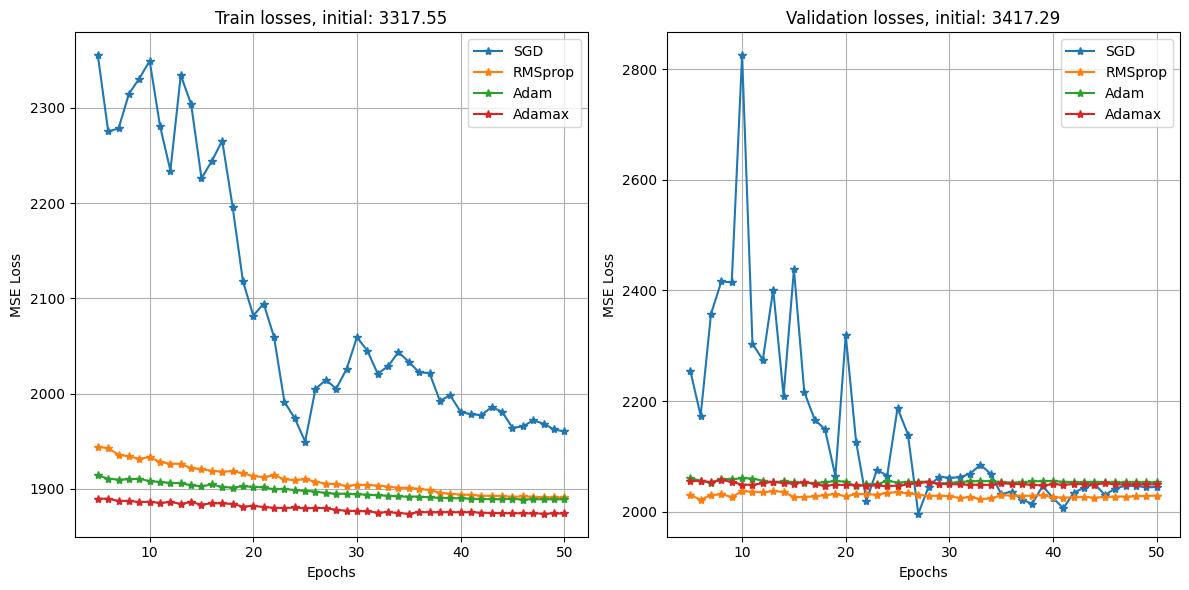

In [26]:
# Plot
plot_dictionaries(
    train_loss_dict,
    val_loss_dict,
    initial_mse_train,
    initial_mse_val,
    f"{experiment_dir}/{EXPERIMENT_NAME}_testing.png",
)

### So for full training we will take SGD, 20 layers with 256 neurouns in each and lr=4e-7

In [27]:
N_EPOCH = 50
RISK_FREE = 0.03
SIGMA = 0.4
LEARNING_RATE = 0.00075178
HIDDEN_LAYER = 24
HIDDEN_WIDTH = 64
EXPERIMENT_NAME = "exp_call_12_gen"
MODEL_TYPE = AmericanPut_gated3
experiment_dir = f"../experiments_dir/{EXPERIMENT_NAME}"
os.makedirs(experiment_dir, exist_ok=True)

In [28]:
logging.info(f"N_EPOCH: {N_EPOCH}")
logging.info(f"LEARNING_RATE: {LEARNING_RATE}")
logging.info(f"HIDDEN_LAYER: {HIDDEN_LAYER}")
logging.info(f"HIDDEN_WIDTH: {HIDDEN_WIDTH}")
# logging.info(f"N_sample: {N_sample}")
logging.info(f"EXPERIMENT_NAME: {EXPERIMENT_NAME}")
logging.info(f"Model type: {MODEL_TYPE.__name__}")

In [29]:
df

,TimeToExp,UnderlyingPrice,TargetPrice,OpenInterest,Delta,Gamma,Theta,Vega,BSAprox
0,850.00,122.12,43.00,364.0,0.345992,0.144298,-3.575622,2.522842,31.500
1,311.00,186.19,29.31,514.0,0.167115,0.056784,-2.531811,6.822075,24.655
2,629.00,52.52,69.69,65.0,0.376269,0.272558,-7.814967,5.852912,0.000
3,469.00,144.80,37.75,58.0,0.009575,0.017516,-1.451383,1.604901,0.000
4,0.00,187.07,29.12,91.0,0.441506,0.138325,-8.777276,5.934998,118.970
...,...,...,...,...,...,...,...,...,...
9995,1089.04,200.00,200.00,54.0,0.189853,0.083916,-31.967621,3.605873,82.030
9996,939.78,200.00,200.00,410.0,0.034537,0.091283,-10.788996,6.799438,82.030
9997,886.42,200.00,200.00,274.0,0.015381,0.324230,-4.528091,7.367978,82.030
9998,560.18,200.00,200.00,586.0,0.275679,0.402972,-4.144945,3.066105,82.030


In [30]:
df_train, df_test = train_test_split(df, test_size=0.2)
logging.info(f"train set size: {df_train.shape}")
logging.info(f"test set size: {df_test.shape}")
initial_mse_train = (
    1 / len(df_train) * np.sum((df_train.TargetPrice - df_train.BSAprox) ** 2)
)
initial_mse_val = (
    1 / len(df_test) * np.sum((df_test.TargetPrice - df_test.BSAprox) ** 2)
)
logging.info(
    f"Initial MSE train: {initial_mse_train.round(4)}, Initial MSE val: {initial_mse_val.round(4)}"
)
train_df = CustomDataset(df_train)
test_df = CustomDataset(df_test)

In [31]:
# import torch.multiprocessing as mp
train_df = CustomDataset(df_train)
val_df = CustomDataset(df_val)
# from torch.optim.lr_scheduler import ReduceLROnPlateau
model = MODEL_TYPE(5, 1, HIDDEN_WIDTH, HIDDEN_LAYER).to(DEVICE)
logging.info(
    f"Total number of learnable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)
train_dataloader = DataLoader(
    train_df,
    batch_size=64,
    shuffle=True,
    num_workers=8,
    # generator=torch.Generator(device=DEVICE),
)
val_dataloader = DataLoader(
    val_df,
    batch_size=64,
    shuffle=False,
    num_workers=8,
)
optimizers_list = {
    "SGD": torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.7)
}
criteriation = nn.MSELoss()

In [33]:
train_loss_dict = {}
test_loss_dict = {}
train_cycle("SGD", optimizers_list["SGD"], train_loss_dict, test_loss_dict)

Optimizer: SGD


100%|██████████| 32/32 [00:00<00:00, 163.12it/s]


Epoch 1, train loss: 1860.6847, test loss: 1910.6102


100%|██████████| 32/32 [00:00<00:00, 165.78it/s]

Epoch 2, train loss: 1789.2217, test loss: 1953.9997



100%|██████████| 32/32 [00:00<00:00, 119.17it/s]

Epoch 3, train loss: 1793.2629, test loss: 1911.4333



100%|██████████| 32/32 [00:00<00:00, 136.10it/s]

Epoch 4, train loss: 1797.5282, test loss: 1914.1728



100%|██████████| 32/32 [00:00<00:00, 127.54it/s]

Epoch 5, train loss: 1787.7645, test loss: 1915.6909



100%|██████████| 32/32 [00:00<00:00, 143.66it/s]

Epoch 6, train loss: 1791.9267, test loss: 1910.9990



100%|██████████| 32/32 [00:00<00:00, 130.91it/s]

Epoch 7, train loss: 1787.8529, test loss: 1936.1527



100%|██████████| 32/32 [00:00<00:00, 160.42it/s]

Epoch 8, train loss: 1787.1684, test loss: 1912.7816



100%|██████████| 32/32 [00:00<00:00, 151.43it/s]

Epoch 9, train loss: 1785.7555, test loss: 1911.8429



100%|██████████| 32/32 [00:00<00:00, 151.76it/s]

Epoch 10, train loss: 1787.7884, test loss: 1916.7225



100%|██████████| 32/32 [00:00<00:00, 115.60it/s]

Epoch 11, train loss: 1784.8655, test loss: 1912.4627



100%|██████████| 32/32 [00:00<00:00, 159.45it/s]

Epoch 12, train loss: 1785.9713, test loss: 1917.5330



100%|██████████| 32/32 [00:00<00:00, 160.65it/s]

Epoch 13, train loss: 1787.1268, test loss: 1913.8998



100%|██████████| 32/32 [00:00<00:00, 156.00it/s]

Epoch 14, train loss: 1784.4453, test loss: 1912.9105



100%|██████████| 32/32 [00:00<00:00, 170.18it/s]

Epoch 15, train loss: 1783.8293, test loss: 1913.1841



100%|██████████| 32/32 [00:00<00:00, 158.33it/s]

Epoch 16, train loss: 1784.9382, test loss: 1916.2510



100%|██████████| 32/32 [00:00<00:00, 157.72it/s]

Epoch 17, train loss: 1782.0666, test loss: 1927.8300



100%|██████████| 32/32 [00:00<00:00, 174.72it/s]

Epoch 18, train loss: 1786.0605, test loss: 1921.2585



100%|██████████| 32/32 [00:00<00:00, 170.80it/s]

Epoch 19, train loss: 1783.6833, test loss: 1917.4883



100%|██████████| 32/32 [00:00<00:00, 167.77it/s]

Epoch 20, train loss: 1783.2330, test loss: 1914.1939



100%|██████████| 32/32 [00:00<00:00, 157.70it/s]

Epoch 21, train loss: 1783.7198, test loss: 1919.9071



100%|██████████| 32/32 [00:00<00:00, 169.76it/s]

Epoch 22, train loss: 1782.7713, test loss: 1919.9515



100%|██████████| 125/125 [00:01<00:00, 81.64it/s]

Epoch 00023: reducing learning rate of group 0 to 3.0000e-06.



100%|██████████| 32/32 [00:00<00:00, 151.89it/s]

Epoch 23, train loss: 1790.2206, test loss: 1920.1964



100%|██████████| 32/32 [00:00<00:00, 159.82it/s]

Epoch 24, train loss: 1778.2833, test loss: 1913.4609



100%|██████████| 32/32 [00:00<00:00, 176.88it/s]

Epoch 25, train loss: 1777.9068, test loss: 1913.6995



100%|██████████| 32/32 [00:00<00:00, 169.33it/s]

Epoch 26, train loss: 1777.7269, test loss: 1913.7575



100%|██████████| 32/32 [00:00<00:00, 177.62it/s]

Epoch 27, train loss: 1778.1664, test loss: 1913.9387



100%|██████████| 32/32 [00:00<00:00, 172.04it/s]

Epoch 28, train loss: 1777.8395, test loss: 1914.1153



100%|██████████| 32/32 [00:00<00:00, 177.52it/s]

Epoch 29, train loss: 1777.7945, test loss: 1914.3630



100%|██████████| 32/32 [00:00<00:00, 171.11it/s]

Epoch 30, train loss: 1777.6664, test loss: 1914.7065



100%|██████████| 32/32 [00:00<00:00, 171.65it/s]

Epoch 31, train loss: 1777.7703, test loss: 1914.4857



100%|██████████| 125/125 [00:01<00:00, 82.93it/s]

Epoch 00032: reducing learning rate of group 0 to 3.0000e-07.



100%|██████████| 32/32 [00:00<00:00, 176.49it/s]

Epoch 32, train loss: 1777.8768, test loss: 1914.9711



100%|██████████| 32/32 [00:00<00:00, 180.54it/s]

Epoch 33, train loss: 1777.3310, test loss: 1914.5801



100%|██████████| 32/32 [00:00<00:00, 162.15it/s]


Epoch 34, train loss: 1776.9110, test loss: 1914.4984


100%|██████████| 32/32 [00:00<00:00, 172.79it/s]

Epoch 35, train loss: 1776.7938, test loss: 1914.5293



100%|██████████| 32/32 [00:00<00:00, 168.01it/s]

Epoch 36, train loss: 1776.7564, test loss: 1914.5607



100%|██████████| 32/32 [00:00<00:00, 159.71it/s]

Epoch 37, train loss: 1776.8068, test loss: 1914.6165



100%|██████████| 32/32 [00:00<00:00, 176.04it/s]

Epoch 38, train loss: 1776.7302, test loss: 1914.6196



100%|██████████| 32/32 [00:00<00:00, 160.78it/s]

Epoch 39, train loss: 1776.7324, test loss: 1914.6827



100%|██████████| 32/32 [00:00<00:00, 176.09it/s]

Epoch 40, train loss: 1776.7918, test loss: 1914.6887



100%|██████████| 32/32 [00:00<00:00, 165.01it/s]

Epoch 41, train loss: 1776.7148, test loss: 1914.6936



100%|██████████| 32/32 [00:00<00:00, 174.17it/s]

Epoch 42, train loss: 1776.7004, test loss: 1914.7154



100%|██████████| 32/32 [00:00<00:00, 158.37it/s]

Epoch 43, train loss: 1776.7042, test loss: 1914.7707



100%|██████████| 125/125 [00:01<00:00, 79.57it/s]

Epoch 00044: reducing learning rate of group 0 to 3.0000e-08.



100%|██████████| 32/32 [00:00<00:00, 164.70it/s]

Epoch 44, train loss: 1776.6900, test loss: 1914.7794



100%|██████████| 32/32 [00:00<00:00, 183.66it/s]

Epoch 45, train loss: 1776.5871, test loss: 1914.7814



100%|██████████| 32/32 [00:00<00:00, 181.19it/s]

Epoch 46, train loss: 1776.5829, test loss: 1914.7817



100%|██████████| 32/32 [00:00<00:00, 154.58it/s]

Epoch 47, train loss: 1776.5775, test loss: 1914.7836



100%|██████████| 32/32 [00:00<00:00, 151.32it/s]

Epoch 48, train loss: 1776.5864, test loss: 1914.7864



100%|██████████| 32/32 [00:00<00:00, 164.71it/s]


Epoch 49, train loss: 1776.5755, test loss: 1914.7868


100%|██████████| 125/125 [00:01<00:00, 81.09it/s]

Epoch 00050: reducing learning rate of group 0 to 3.0000e-09.



100%|██████████| 32/32 [00:00<00:00, 167.90it/s]

Epoch 50, train loss: 1776.5779, test loss: 1914.7862


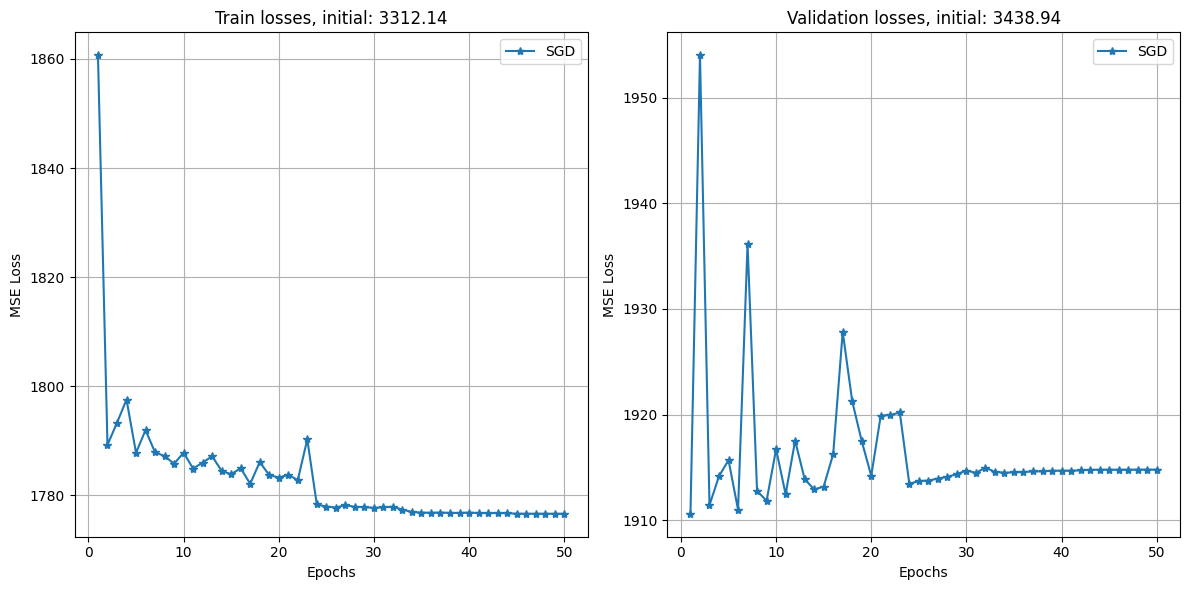

In [34]:
plot_dictionaries(
    train_loss_dict,
    test_loss_dict,
    initial_mse_train,
    initial_mse_val,
    f"{experiment_dir}/{EXPERIMENT_NAME}_final.png",
)

In [35]:
import json

file_path = f"{experiment_dir}/{EXPERIMENT_NAME}_train.json"
with open(file_path, "w") as json_file:
    json.dump(train_loss_dict, json_file)

file_path = f"{experiment_dir}/{EXPERIMENT_NAME}_test.json"
with open(file_path, "w") as json_file:
    json.dump(test_loss_dict, json_file)

In [37]:
logging.info(
    f"% of variation before training: {(initial_mse_train/(df_train.TargetPrice - df_train.BSAprox).var() * 100).round(2)}"
)
logging.info(
    f"% of variation after training: {(train_loss_dict['SGD'][20]/ (df_train.TargetPrice - df_train.BSAprox).var() * 100).round(2)}"
)
logging.info(
    f"% of variation before training: {(initial_mse_val/(df_test.TargetPrice - df_test.BSAprox).var() * 100).round(2)}"
)
logging.info(
    f"% of variation after training: {(test_loss_dict['SGD'][20] / (df_test.TargetPrice - df_test.BSAprox).var() * 100).round(2)}"
)